# Load Dataset and Important Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
np.random.seed(42) # some functions like scipy.stats rely on this being consistent between runs

Load COVID data set.

In [3]:
!wget https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz?raw=true

--2021-05-11 22:11:41--  https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/beoutbreakprepared/nCoV2019/raw/master/latest_data/latestdata.tar.gz [following]
--2021-05-11 22:11:41--  https://github.com/beoutbreakprepared/nCoV2019/raw/master/latest_data/latestdata.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.tar.gz [following]
--2021-05-11 22:11:41--  https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to ra

Unzip the file

In [4]:
!tar -xvf latestdata.tar.gz?raw=true

latestdata.csv


When reasing in the .csv dataset, set  `low memory` to `False` so Pandas does not guess a data type and raise errors.

In [5]:
df = pd.read_csv('latestdata.csv', low_memory=False)
original_df = df.copy()

In [6]:
df.head()

,ID,age,sex,city,province,country,latitude,longitude,geo_resolution,date_onset_symptoms,date_admission_hospital,date_confirmation,symptoms,lives_in_Wuhan,travel_history_dates,travel_history_location,reported_market_exposure,additional_information,chronic_disease_binary,chronic_disease,source,sequence_available,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials,travel_history_binary
0,000-1-1,NaN,male,Shek Lei,Hong Kong,China,22.365019,114.133808,point,NaN,NaN,14.02.2020,NaN,NaN,22.01.2020,China,NaN,Case 55; mainland China travel via the Lok Ma ...,False,NaN,https://www.scmp.com/news/hong-kong/health-env...,NaN,"critical condition, intubated as of 14.02.2020",NaN,NaN,Shek Lei,NaN,NaN,Hong Kong,China,8029.0,NaN,NaN
1,000-1-10,78,male,Vo Euganeo,Veneto,Italy,45.297748,11.658382,point,NaN,NaN,21.02.2020,NaN,NaN,NaN,NaN,NaN,Hospitalized on 12.02.2020 for other reasons,False,NaN,https://www.corriere.it/cronache/20_febbraio_2...,NaN,death,22.02.2020,NaN,Vo' Euganeo,NaN,NaN,Veneto,Italy,8954.0,NaN,NaN
2,000-1-100,61,female,NaN,NaN,Singapore,1.353460,103.815100,admin0,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,"Case 65; family member of Case 50, a DBS emplo...",False,NaN,https://www.channelnewsasia.com/news/singapore...,NaN,discharge,17.02.2020,NaN,NaN,NaN,NaN,NaN,Singapore,200.0,NaN,NaN
3,000-1-1000,NaN,NaN,Zhengzhou City,Henan,China,34.629310,113.468000,admin2,NaN,NaN,26.01.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,https://news.163.com/special/epidemic/?spssid=...,NaN,NaN,NaN,NaN,NaN,NaN,Zhengzhou City,Henan,China,10091.0,NaN,NaN
4,000-1-10000,NaN,NaN,Pingxiang City,Jiangxi,China,27.513560,113.902900,admin2,NaN,NaN,14.02.2020,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,http://hc.jiangxi.gov.cn/doc/2020/02/15/138898...,NaN,NaN,NaN,NaN,NaN,NaN,Pingxiang City,Jiangxi,China,7060.0,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676311 entries, 0 to 2676310
Data columns (total 33 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   ID                        object 
 1   age                       object 
 2   sex                       object 
 3   city                      object 
 4   province                  object 
 5   country                   object 
 6   latitude                  float64
 7   longitude                 float64
 8   geo_resolution            object 
 9   date_onset_symptoms       object 
 10  date_admission_hospital   object 
 11  date_confirmation         object 
 12  symptoms                  object 
 13  lives_in_Wuhan            object 
 14  travel_history_dates      object 
 15  travel_history_location   object 
 16  reported_market_exposure  object 
 17  additional_information    object 
 18  chronic_disease_binary    bool   
 19  chronic_disease           object 
 20  source                  

In [8]:
df.count()

ID                          2676311
age                          578018
sex                          580157
city                        1698630
province                    2223647
country                     2676196
latitude                    2676250
longitude                   2676250
geo_resolution              2676250
date_onset_symptoms          261599
date_admission_hospital      116211
date_confirmation           2567822
symptoms                       2052
lives_in_Wuhan                 4338
travel_history_dates           2611
travel_history_location        9222
reported_market_exposure       1069
additional_information        45855
chronic_disease_binary      2676311
chronic_disease                 215
source                      2109347
sequence_available               12
outcome                      307382
date_death_or_discharge        3148
notes_for_discussion            640
location                      13376
admin3                        80434
admin2                      

Features worth noting in terms of relevance to outcome prediction and availibility in the data set:


1.   `longitude`, `latitude`, `geo_reolution`
2.   `date onset` and `admission`
3. `date_confirmation`
4. `travel_history_binary`
5. `chronic_disease_binary`
6. `outcome`



0 rows are completely filled.

# Data Cleaning
Begin by fixing the data types of the features we intend to use. This involves dropping rows without the neccessary features filled in.

In [8]:
df.dropna(subset=['age', 'sex', 'latitude', 'longitude', 'chronic_disease_binary', 'travel_history_binary', 'outcome'], inplace=True)

In [9]:
# convert age to floats first
# coerce to force any enrties that are age ranges to NaN
df['age'] = pd.to_numeric(df['age'], errors='coerce')

#remove all NaNs
df.dropna(subset=['age'], inplace=True)
df['age'] = df['age'].astype(int)

In [10]:
df.dropna(subset=['travel_history_binary'], inplace=True)

In [11]:
thb_dict = {
    True: True,
    False: False
}

df['travel_history_binary'] = df['travel_history_binary'].map(thb_dict)

Convert `sex` to binary for correlation purposes.

In [12]:
sexdict = {
    'male': True,
    'female': False
}

df['sex'] = df['sex'].map(sexdict)

Convert `outcome` label to boolean.

In [13]:
df['outcome'].unique()

array(['Alive', 'Dead', 'Recovered', 'Stable', 'Died', 'Deceased',
       'stable condition', 'Under treatment', 'Receiving Treatment',
       'severe illness', 'dead', 'critical condition', 'recovered',
       'died', 'discharge', 'discharged', 'stable',
       'released from quarantine', 'death', 'Hospitalized', 'Death'],
      dtype=object)

In [14]:
outdict = {'death': False,
           'discharge': True,
           'discharged': True,
           'Discharged': True,
           'recovered': True,
           'released from quarantine': True,
           'stable': True,
           'Death': False,
           'died': False,
           'Alive': True,
           'Dead': False,
           'Recovered': True,
           'Stable': True,
           'Died': False,
           'Deceased': False,
           'stable condition': True,
           'Under treatment': True,
           'Receiving Treatment': True,
           'severe illness': True,
           'dead': False,
           'critical condition': True,
           'Hospitalized': True}

df['outcome'] = df['outcome'].map(outdict)

Explore `date_confirmation`

Did not end up using this feature in final model.

In [15]:

df['date_confirmation'] = pd.to_datetime(df['date_confirmation'],
                                         format='%d.%m.%Y',
                                         errors='coerce')

In [16]:
print(df['date_confirmation'].dtype)
df['date_confirmation']

datetime64[ns]


66859    2020-03-20
66870    2020-03-21
66892    2020-03-24
66903    2020-03-24
66915    2020-03-24
            ...    
575226   2020-02-28
583617   2020-03-11
614705   2020-04-05
621357   2020-03-13
672674   2020-03-10
Name: date_confirmation, Length: 33314, dtype: datetime64[ns]

In [17]:
print(df['date_confirmation'].min())
print(df['date_confirmation'].max())

2020-01-06 00:00:00
2020-06-03 00:00:00


In [18]:
df['date_confirmation'].dt.month.unique()

array([ 3., nan,  4.,  5.,  2.,  6.,  1.])

`date_confirmation` did not have year long data.

# Data Insights and Statistics

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe1a584bd0>,
      dtype=object)

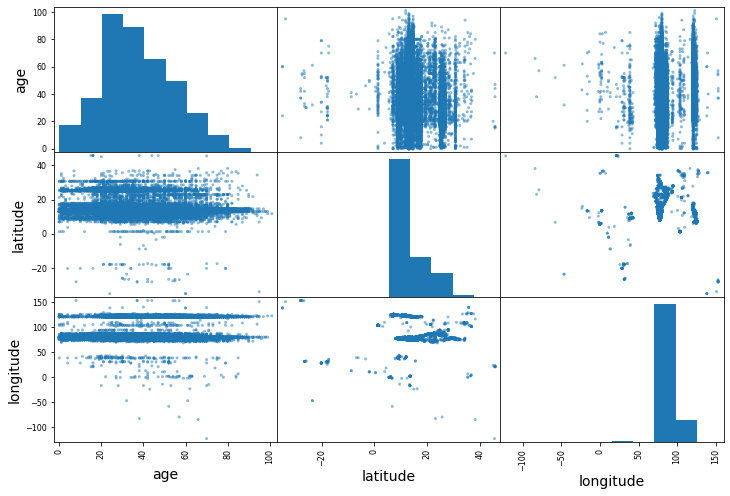

In [19]:
from pandas.plotting import scatter_matrix
attributes = ['age', 'latitude', 'longitude']
scatter_matrix(df[attributes], figsize=(12, 8))

Analyse Pearson's correlation coefficient.

In [20]:
df.corr(method='pearson')

,age,sex,latitude,longitude,chronic_disease_binary,outcome,admin_id,travel_history_binary
age,1.000000,0.007756,-0.106853,0.165195,0.092190,-0.271602,-0.203519,0.046321
sex,0.007756,1.000000,0.114276,-0.072018,0.009139,0.001136,0.099689,0.021977
latitude,-0.106853,0.114276,1.000000,0.046829,-0.005696,-0.025282,0.220251,-0.001686
longitude,0.165195,-0.072018,0.046829,1.000000,0.108936,-0.254930,-0.541306,-0.009456
chronic_disease_binary,0.092190,0.009139,-0.005696,0.108936,1.000000,-0.221205,-0.106018,0.289324
outcome,-0.271602,0.001136,-0.025282,-0.254930,-0.221205,1.000000,0.245731,-0.070111
admin_id,-0.203519,0.099689,0.220251,-0.541306,-0.106018,0.245731,1.000000,-0.161900
travel_history_binary,0.046321,0.021977,-0.001686,-0.009456,0.289324,-0.070111,-0.161900,1.000000


[Text(0.5, 0, 'age'),
 Text(1.5, 0, 'sex'),
 Text(2.5, 0, 'latitude'),
 Text(3.5, 0, 'longitude'),
 Text(4.5, 0, 'chronic_disease_binary'),
 Text(5.5, 0, 'outcome'),
 Text(6.5, 0, 'admin_id'),
 Text(7.5, 0, 'travel_history_binary')]

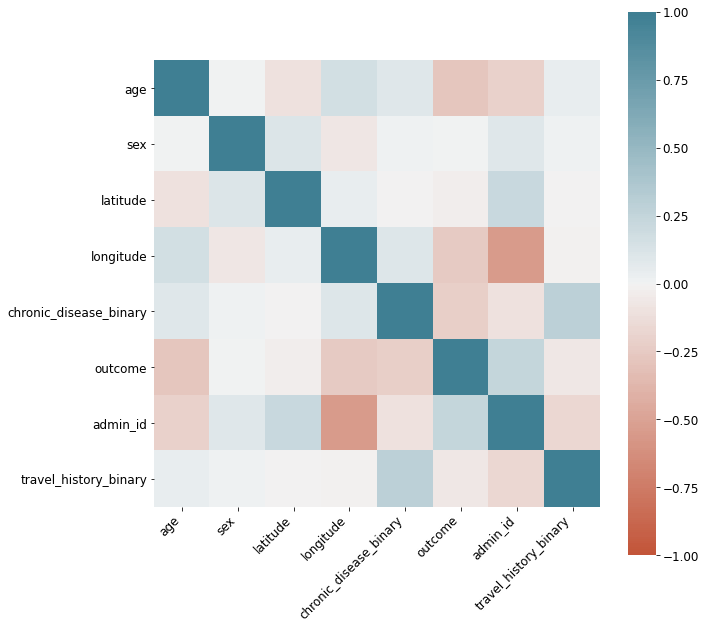

In [21]:
import seaborn as sns
corr = df.corr(method='pearson')
plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

Point Biserial Correlation between age (continuous) and outcome (binary)

In [22]:
stats.pointbiserialr(df['age'], df['outcome'])

PointbiserialrResult(correlation=-0.2716017762887445, pvalue=0.0)

Check if `age` is normally distributed.

In [23]:
stats.shapiro(df['age'])

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9872353076934814, 0.0)

Sample size too big for Shapiro-Wilk test, instead try Kolmogorov Smirnov test.

In [24]:
stats.kstest(df.loc[df['outcome']==True]['age'], 'norm')

KstestResult(statistic=0.987790034561055, pvalue=0.0)

In [25]:
stats.kstest(df.loc[df['outcome']==False]['age'], 'norm')

KstestResult(statistic=0.9866141732270666, pvalue=0.0)

A very high test statistic is found, so age of a positive and negative COVID case are both normally distributed.

Now, check if the mean of the ages differ based on outcomes using a Wilcoxon test on a random sample of each subset since subsets are of different sizes.

In [30]:
df_alive= df.loc[df['outcome']==True].sample(n=1000, random_state=4)
df_dead= df.loc[df['outcome']==False].sample(n=1000,  random_state=4)

In [31]:
stats.wilcoxon(df_alive['age'], df_dead['age'])

WilcoxonResult(statistic=38739.5, pvalue=2.192684799358713e-117)

# Data Preparation

In [32]:
len(df)

33314

Todo: need to fix sex column, use one hot encoding on it!

In [33]:
ml_df = df.copy()
# sex_bin inclued only to check gini importance of RF
ml_df = ml_df[['age', 'sex', 'latitude', 'longitude', 'chronic_disease_binary', 'travel_history_binary', 'outcome']]
ml_df.head()

,age,sex,latitude,longitude,chronic_disease_binary,travel_history_binary,outcome
66859,36,True,13.511667,2.125278,False,False,True
66870,51,True,13.511667,2.125278,False,True,True
66892,63,True,13.511667,2.125278,False,True,True
66903,57,True,13.511667,2.125278,False,True,True
66915,63,False,13.511667,2.125278,False,True,True


Check if there are any nulls.

In [34]:
ml_df.isnull().sum().sort_values()

age                       0
sex                       0
latitude                  0
longitude                 0
chronic_disease_binary    0
travel_history_binary     0
outcome                   0
dtype: int64

Create feature vector and label

In [35]:
# Feature Vector
X = ml_df.drop(columns=['outcome'])
# Label
y = ml_df['outcome']

Perform train test split. 

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_index, test_index in stratified_split.split(ml_df, ml_df['outcome']):
    strat_train_set = ml_df.iloc[train_index]
    strat_test_set = ml_df.iloc[test_index]

In [37]:
print(len(strat_train_set))
print(len(strat_test_set))

23319
9995


In [38]:
# Feature Vectors
X_train = strat_train_set.drop(columns=['outcome'])
X_test = strat_test_set.drop(columns=['outcome'])

# Labels
y_train = strat_train_set['outcome']
y_test = strat_test_set['outcome']

numeric_train_df = X_train.select_dtypes(exclude=['object'])
numeric_test_df = X_test.select_dtypes(exclude=['object'])

# to deal with sex
categorical_train_df = X_train.select_dtypes(['object'])
categorical_test_df = X_test.select_dtypes(['object'])

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
class DFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit (self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [40]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_attributes = list(X_train.select_dtypes(exclude=['object']))
# removed country so i only have a numerical pipeline
cat_attributes = list(X_train.select_dtypes(['object']))



num_pipeline = Pipeline([
                         ('select_numeric', DFSelector(num_attributes)),
                         ('std_sclr', StandardScaler()),
                        ])

cat_pipeline = Pipeline([
                         ('select_categoric', DFSelector(cat_attributes)),
                         ('one_hot', OneHotEncoder()),
                        ])

full_pipeline = ColumnTransformer([
                                    ('num', num_pipeline, num_attributes),
                                    ('cat', cat_pipeline, cat_attributes),
                                ])

X_train_scaled = full_pipeline.fit_transform(X_train)
X_test_scaled = full_pipeline.fit_transform(X_test)

# This is what o reilly does, but i dont think its what im after
# it also reqwuires num_att and cat_att to be based on the entire svm_df
# svm_df_prepared = full_pipeline.fit_transform(svm_df)

Label Scaling

In [41]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_scaled = le.fit_transform(y_train)
y_test_scaled = le.fit_transform(y_test)

In [42]:
from sklearn.metrics import accuracy_score, mean_squared_error, balanced_accuracy_score, jaccard_score, f1_score, confusion_matrix, plot_roc_curve
def performance_metrics(model, X_test, y_test, y_hat):
    print('Accuracy: ', accuracy_score(y_test, y_hat)*100, '%')
    print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(y_test, y_hat)))
    print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_hat)*100, '%')
    print('Jaccard Score: ', jaccard_score(y_test, y_hat, average='weighted')*100, '%')
    print('F1 Score: ', f1_score(y_test, y_hat))

    cm = confusion_matrix(y_test, y_hat)
    print('True Negatives (Correctly Predicted Death): ', cm[0,0])
    print('False Negatives (Incorrectly Predicted as Death): ',  cm[1,0])
    print('True Positives (Correctly Predicted as Alive): ', cm[1,1])
    print('False Positives (Incorrectly Predicted as Alive): ',  cm[0,1])

    print('Sensitivty (Recall/True Positive Rate): ', cm[1,1] / (cm[1,1]+cm[1,0])) # TP/(TP+FN), proportion of actual positives branded as positives
    print('False Positive Rate: ', cm[0,1] / (cm[0,1]+cm[0,0])) # FP/(FP+TN), proportion of actual negatives branded as postives
    print('Specificity: ', cm[0,0] / (cm[0,0]+cm[0,1])) # TN/(TN+FP)
    print('Positive Predictive Value (Precision): ', cm[1,1] / (cm[1,1]+cm[0,1])) # TP/(TP+FP)
    print('Negative Predictive Value: ', cm[0,0] / (cm[0,0]+cm[1,0])) # TN/(TN+FN)

    plot_roc_curve(model, X_test, y_test)
    plt.show

## Support Vector Machine

Create a SVM classifier and perform 10-fold cross validation to get an idea of ifdeal parameters (no fitting to training set yet).

In [43]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

SVM_basemodel = SVC(random_state=42)
scoring = ['accuracy', 'f1', 'precision', 'recall']

scores = cross_validate(SVM_basemodel, X_train_scaled, y_train_scaled, cv = 5,
                        scoring=scoring, return_estimator=True)
sorted(scores.keys())

['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_f1',
 'test_precision',
 'test_recall']

In [44]:
print('Average Accuracy:', scores['test_accuracy'].mean())
print('Average F1:', scores['test_f1'].mean())
print('Average Precision:', scores['test_precision'].mean())
print('Average Recall:', scores['test_recall'].mean())

Average Accuracy: 0.9665080177551904
Average F1: 0.9828524147931358
Average Precision: 0.9682904452504643
Average Recall: 0.9978600089166296


In [45]:
scores['estimator']

(SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
     verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
     verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
     verbose=False),
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
     max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
     verb

In [46]:
SVM_basemodel.fit(X_train_scaled, y_train_scaled)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

Results of default base model with test set.

In [47]:
y_hat_SVM_base = SVM_basemodel.predict(X_test_scaled)

Accuracy:  96.57828914457228 %
Root Mean Squared Error:  0.18497867053873304
Balanced Accuracy:  57.89083286785947 %
Jaccard Score:  93.45359365156582 %
F1 Score:  0.9824848919389533
True Negatives (Correctly Predicted Death):  61
False Negatives (Incorrectly Predicted as Death):  22
True Positives (Correctly Predicted as Alive):  9592
False Positives (Incorrectly Predicted as Alive):  320
Sensitivty (Recall/True Positive Rate):  0.9977116704805492
False Positive Rate:  0.8398950131233596
Specificity:  0.16010498687664043
Positive Predictive Value (Precision):  0.9677158999192897
Negative Predictive Value:  0.7349397590361446


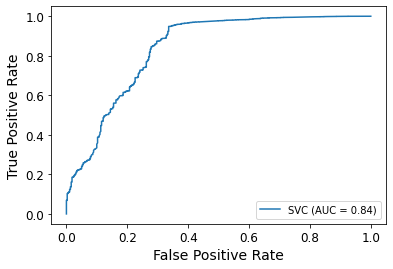

In [48]:
performance_metrics(SVM_basemodel, X_test_scaled, y_test_scaled, y_hat_SVM_base)

Now use random search hyper tuning. Takes approximately 6 to 10 minutes.

In [49]:
from sklearn.model_selection import RandomizedSearchCV
parameter_space = {
    'C': [0.1, 1, 10, 100],
    'gamma': [ 0.1, 1, 10],
}

SVM_tuned =SVC(random_state=42)

SVM_randsearch = RandomizedSearchCV(estimator=SVM_tuned,
                            param_distributions=parameter_space,
                            scoring=scoring,
                            verbose=1, n_jobs=-1,
                            n_iter=1000, refit = 'accuracy') # set refit to false for multi key scoring



SVM_rand_result = SVM_randsearch.fit(X_train_scaled, y_train_scaled)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 12 is smaller than n_iter=1000. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.3min finished


In [50]:
results = SVM_rand_result.cv_results_
dict(results).keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_gamma', 'param_C', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall'])

In [51]:
print('Accuracy: ', dict(results)['mean_test_accuracy'].max())
print('Precision: ', dict(results)['mean_test_precision'].max())
print('Recall: ', dict(results)['mean_test_recall'].max())
print('F1: ', dict(results)['mean_test_f1'].max())

Accuracy:  0.9668939433789376
Precision:  0.9711893898298083
Recall:  0.9994650022291574
F1:  0.9830352587088766


In [52]:
SVM_clf = SVM_rand_result.best_estimator_
SVM_clf.fit(X_train_scaled, y_train_scaled)
y_hat_SVM_tuned = SVM_clf.predict(X_test_scaled)

Results of final tuned model with tests et

Accuracy:  96.58829414707354 %
Root Mean Squared Error:  0.18470803590874066
Balanced Accuracy:  59.03032923880146 %
Jaccard Score:  93.53252376431833 %
F1 Score:  0.9825208877953764
True Negatives (Correctly Predicted Death):  70
False Negatives (Incorrectly Predicted as Death):  30
True Positives (Correctly Predicted as Alive):  9584
False Positives (Incorrectly Predicted as Alive):  311
Sensitivty (Recall/True Positive Rate):  0.9968795506552943
False Positive Rate:  0.8162729658792651
Specificity:  0.1837270341207349
Positive Predictive Value (Precision):  0.9685699848408287
Negative Predictive Value:  0.7


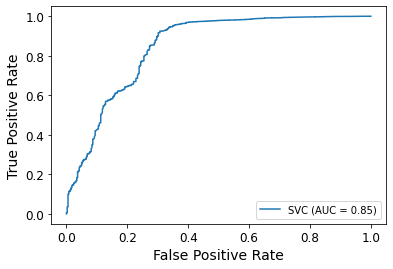

In [53]:
performance_metrics(SVM_clf, X_test_scaled, y_test_scaled, y_hat_SVM_tuned)

---

# Random Forests

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
RF_basemodel = RandomForestClassifier(n_estimators=1000, random_state=42)
scoring = ['accuracy', 'f1', 'precision', 'recall']

scores = cross_validate(RF_basemodel, X_train_scaled, y_train_scaled, cv = 5,
                        scoring=scoring, return_estimator=True)
# print(f'{scores.mean()*100}% accuracy with a standard deviation of {scores.std()}')
sorted(scores.keys())

['estimator',
 'fit_time',
 'score_time',
 'test_accuracy',
 'test_f1',
 'test_precision',
 'test_recall']

metrics from validaiton set for default base model:

In [55]:
print('Average Accuracy:', scores['test_accuracy'].mean())
print('Average F1:', scores['test_f1'].mean())
print('Average Precision:', scores['test_precision'].mean())
print('Average Recall:', scores['test_recall'].mean())

Average Accuracy: 0.9620481425800499
Average F1: 0.980412770791985
Average Precision: 0.9734551494451512
Average Recall: 0.9874721355327687


In [56]:
scores['estimator']

(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=1000,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=1000,
               

In [57]:
RF_basemodel.fit(X_train_scaled, y_train_scaled)
y_hat_RF_base = RF_basemodel.predict(X_test_scaled)

Accuracy:  96.56828414207104 %
Root Mean Squared Error:  0.1852489097924456
Balanced Accuracy:  60.280256209912594 %
Jaccard Score:  93.58148620774482 %
F1 Score:  0.9823985220916508
True Negatives (Correctly Predicted Death):  80
False Negatives (Incorrectly Predicted as Death):  42
True Positives (Correctly Predicted as Alive):  9572
False Positives (Incorrectly Predicted as Alive):  301
Sensitivty (Recall/True Positive Rate):  0.9956313709174122
False Positive Rate:  0.7900262467191601
Specificity:  0.2099737532808399
Positive Predictive Value (Precision):  0.9695128127215639
Negative Predictive Value:  0.6557377049180327


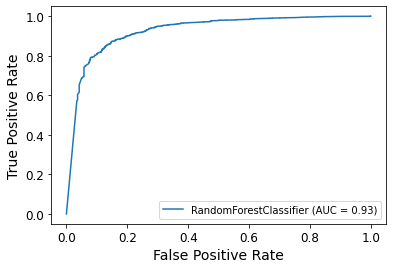

In [58]:
performance_metrics(RF_basemodel, X_test_scaled, y_test_scaled, y_hat_RF_base)

Look at feature importances of base model.

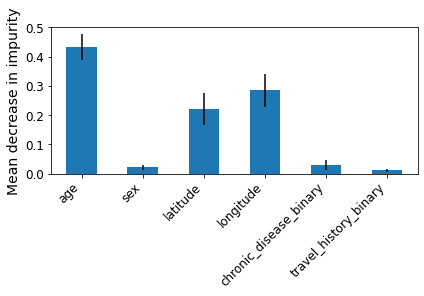

In [59]:
importances = RF_basemodel.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in RF_basemodel.estimators_], axis=0)


forest_importances = pd.Series(importances, index=list(X_train.select_dtypes(exclude=['object'])))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
fig.tight_layout()

Ranges for parameters may appear,narrow, trail and error was used to condfirm that the optimal values lie within this range.
this stiol takes a whilke, so need to cut down the numbrer of fits to try.

In [60]:
from sklearn.model_selection import RandomizedSearchCV
parameter_space = {
    'max_depth': [100, 110],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [6, 8, 10],
    'criterion': ['gini', 'entropy']
}

RF_tuned = RandomForestClassifier(random_state=42)

RF_randsearch = RandomizedSearchCV(estimator=RF_tuned,
                            param_distributions=parameter_space,
                            scoring=scoring,
                            verbose=1, n_jobs=-1,
                            n_iter=500, refit = 'accuracy') # set refit to false for multi key scoring



RF_rand_result = RF_randsearch.fit(X_train_scaled, y_train_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 24 is smaller than n_iter=500. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.6min finished


In [61]:
results = RF_rand_result.cv_results_
dict(results).keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_depth', 'param_criterion', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall'])

In [62]:
print('Accuracy: ', dict(results)['mean_test_accuracy'].max())
print('Precision: ', dict(results)['mean_test_precision'].max())
print('Recall: ', dict(results)['mean_test_recall'].max())
print('F1: ', dict(results)['mean_test_f1'].max())

Accuracy:  0.9671941332978239
Precision:  0.9724658837883566
Recall:  0.9942041908158716
F1:  0.9831362063481087


In [63]:
RF_clf = RF_rand_result.best_estimator_
RF_clf.fit(X_train_scaled, y_train_scaled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [64]:
y_hat_RF_tuned = RF_clf.predict(X_test_scaled)

Accuracy:  96.67833916958479 %
Root Mean Squared Error:  0.1822542408399653
Balanced Accuracy:  59.20316882586473 %
Jaccard Score:  93.6417697618546 %
F1 Score:  0.9829883172781307
True Negatives (Correctly Predicted Death):  71
False Negatives (Incorrectly Predicted as Death):  22
True Positives (Correctly Predicted as Alive):  9592
False Positives (Incorrectly Predicted as Alive):  310
Sensitivty (Recall/True Positive Rate):  0.9977116704805492
False Positive Rate:  0.8136482939632546
Specificity:  0.18635170603674542
Positive Predictive Value (Precision):  0.9686931932942839
Negative Predictive Value:  0.7634408602150538


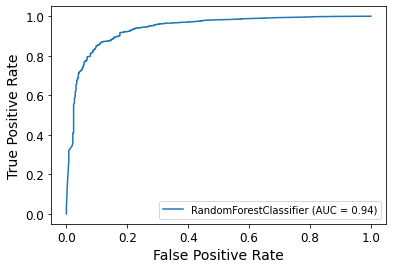

In [65]:
performance_metrics(RF_clf, X_test_scaled, y_test_scaled, y_hat_RF_tuned)

---

# Stochastic Gradient Descent

In [66]:
from sklearn.linear_model import SGDClassifier

In [67]:
from sklearn.model_selection import cross_val_score, cross_validate
scoring = ['accuracy', 'f1', 'precision', 'recall']
SGD_basemodel = SGDClassifier(random_state=42)

# scores = cross_val_score(SGD_basemodel, X_train_scaled, y_train_scaled, cv = 5)
# print(f'{scores.mean()*100}% accuracy with a standard deviation of {scores.std()}')

scores = cross_validate(SGD_basemodel, X_train_scaled, y_train_scaled,scoring=scoring)
sorted(scores.keys())

['fit_time',
 'score_time',
 'test_accuracy',
 'test_f1',
 'test_precision',
 'test_recall']

In [68]:
print('Average Accuracy:', scores['test_accuracy'].mean())
print('Average F1:', scores['test_f1'].mean())
print('Average Precision:', scores['test_precision'].mean())
print('Average Recall:', scores['test_recall'].mean())

Average Accuracy: 0.9632917930984
Average F1: 0.9812670065072855
Average Precision: 0.963679277897654
Average Recall: 0.9995095853767276


In [69]:
SGD_basemodel.fit(X_train_scaled, y_train_scaled)
# SGD_basemodel = scores.best_estimator_
y_hat_SGD_scaled = SGD_basemodel.predict(X_test_scaled)

Accuracy:  96.43821910955478 %
Root Mean Squared Error:  0.18872681024288052
Balanced Accuracy:  53.40687274190581 %
Jaccard Score:  93.0125986673499 %
F1 Score:  0.9818200388111531
True Negatives (Correctly Predicted Death):  26
False Negatives (Incorrectly Predicted as Death):  1
True Positives (Correctly Predicted as Alive):  9613
False Positives (Incorrectly Predicted as Alive):  355
Sensitivty (Recall/True Positive Rate):  0.9998959850218432
False Positive Rate:  0.931758530183727
Specificity:  0.06824146981627296
Positive Predictive Value (Precision):  0.9643860353130016
Negative Predictive Value:  0.9629629629629629


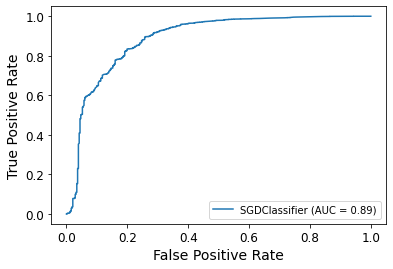

In [86]:
performance_metrics(SGD_basemodel, X_test_scaled, y_test_scaled, y_hat_SGD_scaled)

In [71]:
from sklearn.model_selection import RandomizedSearchCV
parameter_space = {
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'class_weight': [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}],
    'eta0': [1, 10, 100],
}

SGD_tuned = SGDClassifier(random_state=42)

SGD_randsearch = RandomizedSearchCV(estimator=SGD_tuned,
                            param_distributions=parameter_space,
                            scoring=scoring,
                            verbose=1, n_jobs=-1,
                            n_iter=1000, refit = 'accuracy') # set refit to false for multi key scoring

SGD_Xtrain = X_train.drop(columns=['sex'])


SGD_rand_result = SGD_randsearch.fit(X_train_scaled, y_train_scaled)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 468 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 968 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 1908 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2810 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4066 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4997 out of 5000 | elapsed:  5.4min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  5.4min finished


In [74]:
results = SGD_rand_result.cv_results_

In [75]:
dict(results).keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_penalty', 'param_loss', 'param_learning_rate', 'param_eta0', 'param_class_weight', 'param_alpha', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall'])

In [76]:
print('Accuracy: ', dict(results)['mean_test_accuracy'].max())
print('Precision: ', dict(results)['mean_test_precision'].max())
print('Recall: ', dict(results)['mean_test_recall'].max())
print('F1: ', dict(results)['mean_test_f1'].max())

Accuracy:  0.9647068230649737
Precision:  0.9784834286430109
Recall:  1.0
F1:  0.9819371065728723


In [77]:
SGD_rand_result.best_params_

{'alpha': 0.001,
 'class_weight': {0: 0.5, 1: 0.5},
 'eta0': 100,
 'learning_rate': 'adaptive',
 'loss': 'log',
 'penalty': 'l2'}

In [78]:
SGD_clf = SGD_rand_result.best_estimator_
# SGD_clf = SGDClassifier(**SGD_rand_result.best_params_)

In [79]:
SGD_clf.fit(X_train_scaled, y_train_scaled)
y_hat_SGD_tuned = SGD_clf.predict(X_test_scaled)

Accuracy:  96.64832416208104 %
Root Mean Squared Error:  0.1830758268564957
Balanced Accuracy:  58.30533665089243 %
Jaccard Score:  93.55483807515881 %
F1 Score:  0.9828442669124801
True Negatives (Correctly Predicted Death):  64
False Negatives (Incorrectly Predicted as Death):  18
True Positives (Correctly Predicted as Alive):  9596
False Positives (Incorrectly Predicted as Alive):  317
Sensitivty (Recall/True Positive Rate):  0.9981277303931766
False Positive Rate:  0.8320209973753281
Specificity:  0.1679790026246719
Positive Predictive Value (Precision):  0.9680217895692524
Negative Predictive Value:  0.7804878048780488


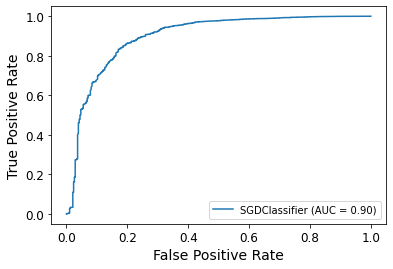

In [87]:
performance_metrics(SGD_clf, X_test_scaled, y_test_scaled, y_hat_SGD_tuned)